<a href="https://colab.research.google.com/github/CT-Cultures/Content/blob/master/RegOverview_Issue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[0] Mount Google Drive

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# [1] Setting up Environment and Install Requirements

In [159]:
%%capture
import os
import sys
import gc

# Install Requirements
!pip install -r /content/drive/MyDrive/Github/Content/sources/ChinaFilm/requirements.txt

# Install Chromedriver
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [160]:
#Load Libraries Global
import datetime as dt

import re
import pandas as pd
import numpy as np
import torch
from bs4 import BeautifulSoup

from selenium import webdriver

import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.font_manager as fm

path_fonts = '/content/drive/MyDrive/Github/Article/fonts'
fontprop = fm.FontProperties(fname=path_fonts, size= 15)

font_dirs = [path_fonts, ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)
font_list = fm.createFontList(font_files)
for font in font_files:
  fm.fontManager.addfont(font)

plt.rcParams['figure.figsize'] = [15, 9]
mp.rcParams['font.family'] = ['Microsoft YaHei']

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


In [161]:
print(mp.get_cachedir())

/root/.cache/matplotlib


In [162]:
# Load Libraries Local
path_Content = '/content/drive/MyDrive/Github/Content'
os.chdir(path_Content)

#%load_ext autoreload
%reload_ext autoreload

from sources.ChinaFilm.Record_Registration import Registration
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# Initialize Registration Class
driver = webdriver.Chrome('chromedriver',options=chrome_options)
dy_reg = Registration(driver)

In [163]:
# Set Path
path_wd = '/content/drive/MyDrive/Github/Article'
path_font = '/content/drive/MyDrive/Github/Article/fonts/STHUPO.TTF'
path_img = '/content/drive/MyDrive/Github/Article/img'
path_reg = '/content/drive/MyDrive/Github/Content/sources/ChinaFilm'

os.chdir(path_wd)

# [2] Import Datasets

### Update Records First

In [ ]:
# Update Release Records
path_reg = '/content/drive/MyDrive/Github/Content/sources/ChinaFilm'
os.chdir(path_reg)
#!python Update_Release.py

In [ ]:
# Update Reg Records
path_reg = '/content/drive/MyDrive/Github/Content/sources/ChinaFilm'
os.chdir(path_reg)
#!python Update_Registration.py

### Import Records

In [164]:
# Import Registration
df = pd.read_json(path_reg + '/records/contents_of_registrations.json')
df = dy_reg.Refined_Records(df)

In [165]:
# Identify Current Issue
curr_issue_name = df.sort_values(['公示日期', '公示批次名称'], ascending=False)['公示批次名称'].iloc[0]
df_curr =  df.loc[df.公示批次名称 == curr_issue_name]
issue_name = df_curr['公示批次起始'].iloc[0][0] + '年' + df_curr['公示批次起始'].iloc[0][1] +'月'
issue_name += df_curr['公示批次起始'].iloc[0][2]
print(issue_name)

2021年8月整月


## Apply Models

### Predict Title

In [ ]:
%%capture
from transformers import BertTokenizer, BartForConditionalGeneration

# assign device
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

# Instantiate tokenizer and model
checkpoint = "/content/drive/MyDrive/Github/Content/tools/models/PredTitle-10000"

tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = BartForConditionalGeneration.from_pretrained(checkpoint)
model.to(device)
model.eval()

In [ ]:
batch_size = 8
i = 0
ls = df_curr['梗概'].tolist()
L = df_curr.shape[0]
test_predictions = []

while i < L:
  inputs = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  inputs.to(device)
  summary_ids = model.generate(input_ids=inputs['input_ids'],
                             num_beams=4,
                             min_length=0,
                             max_length=32
                             )
  
  ret = [tokenizer.decode(g, 
                         skip_specical_tokens=True, 
                         clean_up_tokenization_spaces=True) for g in summary_ids]
  test_predictions.extend(ret)
  i += batch_size

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


In [ ]:
df_curr['预测片名'] = test_predictions

def remove_specials(x):
  x = re.sub(' ', '', x)
  x = re.sub('\[CLS\]', '', x)
  x = re.sub('\[PAD\]', '', x)
  x = re.sub('\[SEP\]', '', x)
  return x

df_curr['预测片名'] = df_curr['预测片名'].apply(remove_specials)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
df_curr['预测片名']

0           直播
1       我的电影女友
2        王家坝开闸
3         家住长安
4      中国国际行动队
        ...   
206     用眼护眼常识
207       安全驾驶
208      熬夜的危害
209      救亡·复兴
210       探秘之旅
Name: 预测片名, Length: 211, dtype: object

### Predict Genre

In [ ]:
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from datasets import Dataset
from transformers import TrainingArguments, Trainer

In [ ]:
path_wd = '/content/drive/MyDrive/Github/Content'
path_NRTA = '/content/drive/MyDrive/Github/Content/sources/NRTA'

In [ ]:
label2id_time = {'古代': 0, '当代': 1, '现代': 2, '近代': 3}
id2label_time = {}
for k, v in label2id_time.items(): id2label_time[v] = k


label2id_genre= {'传奇': 0, '传记': 1, '其它': 2, '军旅': 3, '农村': 4, '宫廷': 5,  
                  '武打': 6, '涉案': 7, '神话': 8, '科幻': 9, '都市': 10, '青少': 11,
                  '革命': 12}
id2label_genre = {}
for k, v in label2id_genre.items(): id2label_genre[v] = k


In [ ]:
%%capture
# Genre Classifier
N_LABELS = len(id2label_genre)
ID2LABEL = id2label_genre
LABEL2ID = label2id_genre

from transformers import BertTokenizer, BertForSequenceClassification
import torch
############
model_name = '/content/drive/MyDrive/Github/Content/tools/models/chinese-bert-wwm-classification-NRTAgenre'
############
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
  model_name,
  num_labels=N_LABELS,
  problem_type="multi_label_classification",
  id2label=ID2LABEL,
  label2id=LABEL2ID,  
).to(device)
model.eval() # set model to eval mode for faster prediction

In [ ]:
batch_size = 8
i = 0
ls = df_curr['梗概'].tolist()
softmax = torch.nn.Softmax(dim=-1)
L = df_curr.shape[0]
test_predictions = []

while i < L:
  batch_test = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  batch_test.to(device)
  batch_outputs = model(**batch_test)
  batch_logtis = batch_outputs.logits
  batch_softmax = softmax(batch_logtis)
  batch_results = torch.argmax(batch_softmax, dim=1).cpu().numpy()
  test_predictions.extend(list(batch_results))
  i += batch_size

df_curr['类型'] = test_predictions
df_curr['类型'] = df_curr['类型'].apply(lambda x: id2label_genre[x])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Predict Time Period

In [ ]:
%%capture
# Time Classifier

N_LABELS = len(id2label_time)
ID2LABEL = id2label_time
LABEL2ID = label2id_time

from transformers import BertTokenizer, BertForSequenceClassification
import torch
############
model_name = '/content/drive/MyDrive/Github/Content/tools/models/chinese-bert-wwm-classification-NRTAtime'
############
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
  model_name,
  num_labels=N_LABELS,
  problem_type="multi_label_classification",
  id2label=ID2LABEL,
  label2id=LABEL2ID,  
).to(device)
model.eval() # set model to eval mode for faster prediction

In [ ]:
batch_size = 8
i = 0
ls = df_curr['梗概'].tolist()
softmax = torch.nn.Softmax(dim=-1)
L = df_curr.shape[0]
test_predictions = []

while i < L:
  batch_test = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  batch_test.to(device)
  batch_outputs = model(**batch_test)
  batch_logtis = batch_outputs.logits
  batch_softmax = softmax(batch_logtis)
  batch_results = torch.argmax(batch_softmax, dim=1).cpu().numpy()
  test_predictions.extend(list(batch_results))
  i += batch_size

df_curr['年代'] = test_predictions
df_curr['年代'] = df_curr['年代'].apply(lambda x: id2label_time[x])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Extract top keywords

In [ ]:
import jieba.analyse
tfidf = jieba.analyse.extract_tags
textrank = jieba.analyse.textrank

df_curr['kw'] = df_curr['梗概'].apply(textrank, topK=10)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.069 seconds.
Prefix dict has been built successfully.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Identify Main Characters

In [ ]:
import jieba
import jieba.posseg as pseg
jieba.enable_paddle() #启动paddle模式。 0.40版之后开始支持，早期版本不支持

Installing paddle-tiny, please wait a minute......
Paddle enabled successfully......


In [ ]:
# 识别主要角色
def find_PER(x: pd.Series):
  words = pseg.cut(x, use_paddle=True)
  ls_PER = []
  for word, flag in words:
    if flag == 'PER':
      word = word.strip('[\s,，。、“”？；]')
      ls_PER.append(word)
  ls_PER = list(set(ls_PER))

  ls_PER1 = ls_PER.copy()
  ls_PER = []
  while ls_PER1:
    PER =  ls_PER1.pop(0)
    ls_tmp = re.split('[\s,，。、“”？；]', PER)
    ls_PER.extend(ls_tmp)

  ls_PER = list(set(ls_PER)) 
  ls_PER = [PER for PER in ls_PER if len(PER) > 1]
  ls_PER_sorted = sorted(ls_PER, reverse=False, key=lambda x: len(x))

  ans = []
  while ls_PER_sorted:
    PER = ls_PER_sorted.pop(0)
    i = 0
    while i < len(ls_PER_sorted):
      if re.search(PER, ls_PER_sorted[i]):
        ls_PER_sorted.pop(i)
        ans.append(PER)
      i += 1
    if PER not in ans:
      ans.append(PER)

  return ans

In [ ]:
df_curr['主要角色'] = df_curr['梗概'].apply(find_PER)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### adjust genre

In [ ]:
df_curr['修正类型'] = df_curr['类型'].copy()

In [ ]:
df_curr.loc[2, '修正类型'] = '农村'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
HTML(df_curr[['片名', '修正类型', '梗概']][0:20].to_html())

In [ ]:
df[['片名', '类型', '修正类型', '梗概']]

,片名,类型,修正类型,梗概
0,青春作伴好还乡,农村,农村,管松江带领以赵萌萌、李艳文为代表的一群年轻人在党的精准扶贫政策引领下，帮助洮西县脱贫致富，下...
1,孙悟空大战红孩儿（绍剧）,传奇,传奇,唐僧师徒西行取经，被八百里火焰山挡住去路。“火云洞”洞主红孩儿，凭着口吐“三昧神火”的小技，...
2,刺客道,传奇,传奇,明朝天启年间，出身卑微的殷影织遇到一个存在上千年的刺客组织“暗影会”，被告知自己身上流着刺客...
3,最佳射手,都市,青少,从小痴迷足球的林俊凯立志成为一名职业球员。争得父母同意后来到专业足校受训，因缺乏专业训练遭到...
4,光泽之夏,其它,都市,叛逆的地质大学学生林泽和性格古怪的父亲林光启生活在一起，时常发？？盾，相反却和身在美国的母亲...
5,虚拟的谎言,都市,都市,与徐泽相亲的对象各个另类，最后都成了他的前女友，后来徐泽与苏甜甜一见钟情。在水苼帮助下，徐泽...
6,世界唯一一个你,都市,都市,实习医生陈筱澜与音乐系学生穆阳一见倾心，成为一对甜蜜恋人。然而好景不长，陈筱澜突患癌症。不忍...
7,我们的岁月,都市,都市,该影片讲述了在那个特殊的时代，一群热血青年如何将他们的中国梦一步一步落在实处，如何在时代巨变...
8,绿皮小火车,都市,都市,通过一名大夫的视角，展现石嘴山市建市60来的光辉历程，从一个戈壁滩建成现在的工山水园林工业...
9,红麦,革命,革命,:中国工农红军二、六军团长征过丽江。电影《红麦》以此为背景，讲述了红军女战士与纳西族汉子共克...


## Save / Load Reg_Issue

In [ ]:
# Save records for current release issue
#df_curr.to_pickle(path_wd + '/records/df_reg_{}.pkl'.format(issue_name))

In [166]:
df_curr = pd.read_pickle(path_wd + '/records/df_reg_{}.pkl'.format(issue_name))

# [3] Generating Article Contents

## 【T1】 2021年8月电影备案公示划重点

In [ ]:
# Title
T1 = '{year}年'.format(year=df_curr.iloc[0]['公示批次起始'][0])
T1 += '{month}月'.format(month=df_curr.iloc[0]['公示批次起始'][1])
if df_curr.iloc[0]['公示批次起始'][2] != '整月':
  T1 += '{duration}'.format(duration=df_curr.iloc[0]['公示批次起始'][2])
T1 += '电影备案公示划重点'
print(T1)

2021年8月电影备案公示划重点


## 【P1】	2021年9月30日，8月整月的备案公示新鲜出炉！这一批次中，最遥远的项目是《东方欲晓之曙光》，备案号为影特备字〔2021〕第011号，最近期的项目是《你是我天使2》，备案号为影剧备字〔2021〕第2569号。


In [224]:
# Obtain Variables
df_curr.loc[:,'公示日期'] = df_curr.loc[:,'公示日期'].astype('datetime64')
pub_year = df_curr.iloc[0]['公示日期'].year
pub_month = df_curr.iloc[0]['公示日期'].month
pub_day = df_curr.iloc[0]['公示日期'].day
df_curr['备案申请年份'] = df_curr['备案申请年份'].astype('int')
df_curr_sorted = df_curr.sort_values(
    ['备案申请年份', '备案立项年度顺序号'], ascending=True
).reset_index(drop=True)
df_type = df_curr.groupby('电影类别')['电影类别'].count().sort_values(
    ascending=False).rename('数量').to_frame().reset_index()

# Write Content
P1 = ''
P1 += '{year}年{month}月{day}日，'.format(year=pub_year, month=pub_month, day=pub_day)
P1 += '{month}月{part_of_month}的备案公示新鲜出炉，'.format(
    month=df_curr.iloc[0]['公示批次起始'][1], part_of_month=df_curr.iloc[0]['公示批次起始'][2])
P1 += '共计影片{}部！'.format(df_curr.shape[0])
P1 += '这一批次中，最遥远的项目是《{}》，'.format(df_curr_sorted.loc[0, '片名']) 
P1 += '备案号为{}，'.format(df_curr_sorted.loc[0, '备案立项号'])
P1 += '最近期的项目是《{}》，'.format(df_curr_sorted.loc[df_curr.shape[0]-1, '片名'])
P1 += '备案号为{}。'.format(df_curr_sorted.loc[df_curr.shape[0]-1, '备案立项号'])
print(P1)

2021年9月30日，8月整月的备案公示新鲜出炉，共计影片211部！这一批次中，最遥远的项目是《东方欲晓之曙光》，备案号为影特备字〔2021〕第011号，最近期的项目是《你是我天使2》，备案号为影剧备字〔2021〕第2569号。


## 【P2】按备案类别划分本次完成备案的共计故事影片184部、动画影片9部、科教影片9部、纪录影片7部以及特种影片2部。

<Figure size 432x252 with 0 Axes>

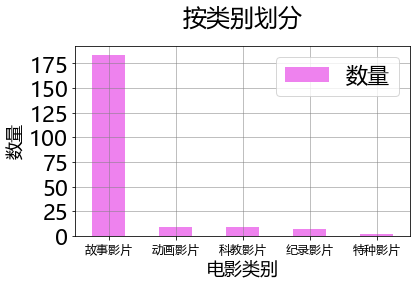

In [232]:
df_n_type = df_curr.groupby('电影类别')['电影类别'].count().rename('数量'
  ).reset_index().sort_values('数量', ascending=False)

plt.clf()
plt.rcParams['figure.figsize'] = [6, 3.5]
plt.rcParams['axes.facecolor'] = 'white'
ax = df_n_type.plot(
    kind = 'bar',
    grid = True,
    fontsize = 22,
    rot = 0,
    color = ['violet'],
)
ax.set_title("按类别划分",fontsize= 24, pad=20)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.set_xlabel('电影类别',fontsize= 18)
ax.set_xticklabels(df_n_type['电影类别'], fontsize=12)
ax.set_ylabel("数量",fontsize= 18)
ax.legend(fontsize=22)

fp_plot_type = path_img + '/df_Reg_plot_type_{}.png'.format(issue_name)
plt.savefig(fp_plot_type, bbox_inches='tight')

plt.show()

In [233]:
P2 = '按备案类别划分本次完成备案的共计'
for i, row in df_type.iterrows():
  if i == df_type.shape[0]-1:
    P2 = P2.rstrip('、')
    P2 += '以及{type}{n}部。'.format(type=row['电影类别'], n=row['数量'])
  else:
    P2 += '{type}{n}部、'.format(type=row['电影类别'], n=row['数量'])
print(P2)

按备案类别划分本次完成备案的共计故事影片184部、动画影片9部、科教影片9部、纪录影片7部以及特种影片2部。


## 【P3】 按类型划分，都市题材最多。

<Figure size 432x252 with 0 Axes>

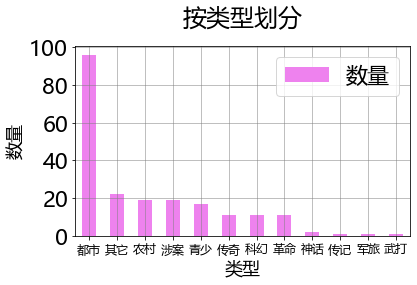

In [227]:
df_n_genre = df_curr.groupby('修正类型')['修正类型'].count().rename('数量'
  ).reset_index().sort_values('数量', ascending=False)

plt.clf()
plt.rcParams['figure.figsize'] = [6, 3.5]
plt.rcParams['axes.facecolor'] = 'white'
ax = df_n_genre.plot(
    kind = 'bar',
    grid = True,
    fontsize = 22,
    rot = 0,
    color = ['violet'],
)
ax.set_title("按类型划分",fontsize= 24, pad=20)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.set_xlabel('类型',fontsize= 18)
ax.set_xticklabels(df_n_genre['修正类型'], fontsize=12)
ax.set_ylabel("数量",fontsize= 18)
ax.legend(fontsize=22)

fp_plot_genre = path_img + '/df_Reg_plot_genre_{}.png'.format(issue_name)
plt.savefig(fp_plot_genre, bbox_inches='tight')

plt.show()

In [228]:
P3 = ''
P3 = '按类型划分，都市题材最多,'
df_genre_sorted = df_curr.groupby('类型')['片名'].count().sort_values(ascending=False).reset_index()
df_genre_sorted.columns = ['类型', '数量']

P3 += '共计{}部。'.format(df_genre_sorted['数量'][0])

print(P3)

按类型划分，都市题材最多,共计96部。


## 【P4】 按年代划分，当代题材占主力位置。

In [229]:
df_curr.columns

Index(['电影类别', '备案立项号', '片名', '备案单位', '编剧', '备案结果', '备案地', '梗概', '公示日期',
       '公示批次名称', '备案详细页链接', '公示批次链接', '公示年', '公示批次起始', '类型', '备案申请年份',
       '备案立项年度顺序号', '公示覆盖期间', '公示覆盖天数', '预测片名', '年代', 'kw', '主要角色', '修正类型',
       'focus'],
      dtype='object')

<Figure size 432x252 with 0 Axes>

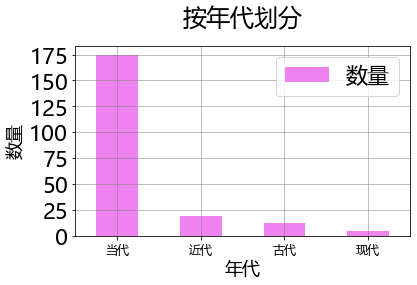

In [230]:
df_n_time = df_curr.groupby('年代')['年代'].count().rename('数量'
  ).reset_index().sort_values('数量', ascending=False)

plt.clf()
plt.rcParams['figure.figsize'] = [6, 3.5]
plt.rcParams['axes.facecolor'] = 'white'
ax = df_n_time.plot(
    kind = 'bar',
    grid = True,
    fontsize = 22,
    rot = 0,
    color = ['violet'],
)
ax.set_title("按年代划分",fontsize= 24, pad=20)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.set_xlabel('年代',fontsize= 18)
ax.set_xticklabels(df_n_time['年代'], fontsize=12)
ax.set_ylabel("数量",fontsize= 18)
ax.legend(fontsize=22)

fp_plot_time = path_img + '/df_Reg_plot_time_{}.png'.format(issue_name)
plt.savefig(fp_plot_time, bbox_inches='tight')

plt.show()

In [231]:
P4 = ''
P4 = '按年代划分，当代题材占主力位置,'
df_time_sorted = df_curr.groupby('年代')['片名'].count().sort_values(ascending=False).reset_index()
df_time_sorted.columns = ['年代', '数量']

P4 += '共计{}部。'.format(df_time_sorted['数量'][0])
print(P4)

按年代划分，当代题材占主力位置,共计175部。


## 【P5】本批次中，大数据分析识别出8部上市影视公司关联项目，占比3.79%。结合题材与出品方实力，慷田AI聚焦关注《嘿，哥们》、《刀·风》、《喜从天降》、《筐出未来》、《贝肯熊3：火星任务》，题材覆盖都市、涉案、科幻。

In [234]:
# 本批次中与上市影视公司关联的项目有
info_public_film_co = pd.read_csv('/content/drive/MyDrive/Github/Article/reference/info_public_film_co.csv', index_col=0, encoding='utf-8-sig')
ls = info_public_film_co['公司简称'].apply(eval).sum()
pat_public = '|'.join(ls)
pat_public += '|阿里|腾讯|爱奇艺|英皇|寰亚|银都|美亚|大盛|儒意|灿星|横店'
df_focus = df_curr.loc[df_curr['备案单位'].str.contains(pat_public), :]
df_focus

,电影类别,备案立项号,片名,备案单位,编剧,备案结果,备案地,梗概,公示日期,公示批次名称,备案详细页链接,公示批次链接,公示年,公示批次起始,类型,备案申请年份,备案立项年度顺序号,公示覆盖期间,公示覆盖天数,预测片名,年代,kw,主要角色,修正类型,focus
26,故事影片,影剧备字〔2021〕第2472号,逆袭记,北京中视皮皮影业有限公司,赵波,同意拍摄,北京市,事业爱情处于低谷的保镖张小明，双目失明妻子又身患重病的音乐家李昂，刚刚出狱却被敲了竹杠的大盗...,2021-09-30,国家电影局关于2021年8月全国电影剧本（梗概） 备案、立项公示的通知-电影备案立项公示-...,http://www.chinafilm.gov.cn/chinafilm/utils/se...,http://www.chinafilm.gov.cn/chinafilm/contents...,2021,"(2021, 8, 整月, 8, 整月)",都市,2021,2472,"DatetimeIndex(['2021-08-01', '2021-08-02', '20...",31,小提琴,当代,"[音乐家, 保镖, 爱情, 处于, 低谷, 重病, 身患, 竹杠, 重金, 时机]","[李昂, 张小明]",都市,False
37,故事影片,影剧备字〔2021〕第2563号,嘿，哥们,万达影视传媒有限公司,孙陶,同意拍摄,北京市,宇超因一次体育比赛，意外丧失了感知能力，恰逢多年未见的哥哥浩博出狱，兄弟感情已岌岌可危的两人...,2021-09-30,国家电影局关于2021年8月全国电影剧本（梗概） 备案、立项公示的通知-电影备案立项公示-...,http://www.chinafilm.gov.cn/chinafilm/utils/se...,http://www.chinafilm.gov.cn/chinafilm/contents...,2021,"(2021, 8, 整月, 8, 整月)",都市,2021,2563,"DatetimeIndex(['2021-08-01', '2021-08-02', '20...",31,重返赛场,当代,"[哥哥, 浩博, 丧失, 恰逢, 突遭, 兄弟二人, 心结, 能力, 感知, 感情]","[浩博, 宇超]",都市,True
71,故事影片,影剧备字〔2021〕第2539号,刀·风,腾讯影业（深圳）有限公司,吴孟璋,同意拍摄,广东省,1992年，阳井市矿区发生了连环杀人案，矿区分局刑警李跃新奉命调查，却几次与凶手擦肩而过，凶...,2021-09-30,国家电影局关于2021年8月全国电影剧本（梗概） 备案、立项公示的通知-电影备案立项公示-...,http://www.chinafilm.gov.cn/chinafilm/utils/se...,http://www.chinafilm.gov.cn/chinafilm/contents...,2021,"(2021, 8, 整月, 8, 整月)",涉案,2021,2539,"DatetimeIndex(['2021-08-01', '2021-08-02', '20...",31,追凶者,当代,"[矿区, 凶案, 追凶, 决定, 分局, 连环, 杀人案, 发生, 凶手, 留下]",[李跃新],涉案,True
109,故事影片,影剧备字〔2021〕第2391号,喜从天降,万达影业（长春）有限公司,孙延昊,同意拍摄,吉林省,故事讲述了离婚在即的小夏和小涛因民政局推行的新政策“离婚冷静期”暂缓离婚，此时小夏却获得意外...,2021-09-30,国家电影局关于2021年8月全国电影剧本（梗概） 备案、立项公示的通知-电影备案立项公示-...,http://www.chinafilm.gov.cn/chinafilm/utils/se...,http://www.chinafilm.gov.cn/chinafilm/contents...,2021,"(2021, 8, 整月, 8, 整月)",都市,2021,2391,"DatetimeIndex(['2021-08-01', '2021-08-02', '20...",31,离婚冷静期,当代,"[离婚, 故事, 考验, 小夏, 重拾, 信任, 政策, 生活, 建立, 讲述]","[小夏, 小涛]",都市,True
124,故事影片,影剧备字〔2021〕第2524号,三个彩蛋,宁夏中视影业有限公司,金缪,同意拍摄,宁夏回族自治区,蓝波的父亲因故去世，只留给他一辆破捷达轿车，两个毒贩偷走这辆车用以贩毒，蓝波一路追车，途中竟...,2021-09-30,国家电影局关于2021年8月全国电影剧本（梗概） 备案、立项公示的通知-电影备案立项公示-...,http://www.chinafilm.gov.cn/chinafilm/utils/se...,http://www.chinafilm.gov.cn/chinafilm/contents...,2021,"(2021, 8, 整月, 8, 整月)",涉案,2021,2524,"DatetimeIndex(['2021-08-01', '2021-08-02', '20...",31,破捷达,当代,"[警方, 因故, 偷走, 拿到, 协助, 贩毒, 用以, 毒贩, 犯罪, 证据]",[蓝波],涉案,False
138,故事影片,影剧备字〔2021〕第2432号,大漠豪侠,陕西芒果影视文化有限公司,张佳垒,同意拍摄,陕西省,故事讲述了饥荒时期，以田闯为首的“大漠豪侠”组合，利用人民的智慧与当地恶势力疤哥和刘麻子周旋...,2021-09-30,国家电影局关于2021年8月全国电影剧本（梗概） 备案、立项公示的通知-电影备案立项公示-...,http://www.chinafilm.gov.cn/chinafilm/utils/se...,http://www.chinafilm.gov.cn/chinafilm/contents...,2021,"(2021, 8, 整月, 8, 整月)",传奇,2021,2432,"DatetimeIndex(['2021-08-01', '2021-08-02', '20...",31,大漠豪侠,近代,"[故事, 时期, 组合, 豪侠, 饥荒, 讲述, 利用, 大漠, 为首, 人民]","[田闯, 疤哥, 周旋, 刘麻子]",传奇,False
187,动画影片,影动备字〔2021〕第080号,筐出未来,奥飞影业（上海）有限公司、广东原创动力文化传播有限公司,吴潮威、耿漪淼、刘泽敏、刘维,同意拍摄,上海市,守护者队参战篮球顶级赛事都市杯，喜羊羊和灰太狼却因为一球之争关系破裂，导致球队惨遭败北，分崩...,2021-09-30,国家电影局关于2021年8月全国电影剧本（梗概） 备案、立项公示的通知-电影备案立项公示-...,http://www.chinafilm.gov.cn/chinafilm/utils/se...,http://www.chinafilm.gov.cn/chinafilm/contents...,2021,"(2021, 8, 整月, 8, 整月)",都市,2021,80,"DatetimeIndex(['2021-08-01', '2021-08-02', '20...",31,都市杯,当代,"[都市, 破裂, 球队, 导致, 成长, 众人, 顶级, 篮球, 参战, 打倒]","[喜羊羊, 灰太狼]",都市,True
188,动画影片,影动备字〔2021〕第081号,贝肯熊3：火星任务,奥飞影业（上海）有限公司,刘珮如、王超,同意拍摄,上海市,最倒霉的特工贝肯熊，为了重获认可，偷偷混入火星任务，不料却闯进了火星里的神秘世界，和要抓捕的...,2021-09-30,国家电影局关于2021年8月全国电影剧本（梗概） 备案、立项公示的通知-电影备案立项公示-...,http://www.chinafilm.gov.cn/chinafilm/utils/se...,http://www.chinafilm.gov.cn/chinafilm/contents...,2021,"(2021, 8, 整月, 8, 整月)",科幻,2021,81,"DatetimeIndex(['2021-08-01', '2021-08-02', '20...",31,特工贝肯熊,当代,"[火星, 混入, 不料, 朋友, 面临, 考验, 抓捕, 特工, 成为, 怪物]",[贝肯熊],科幻,True


In [235]:
pat_public

'中广|欢瑞|文投|苏宁|中视|吉视|吉翔|广厦|横店|中原|上海电影|大晟文化|泰禾|京西文化|北京文化|华数|中南|泛海|瀚叶|时代出版|世茂|中国电影|中影,|浙文|鹿港|东方明珠|当代文体|当代明诚|明诚|江苏有线|喜临门|当代|当代东方|电广传媒|湖南电广|祥源文化|祥源|皇氏|鼎龙|美盛|围海|宇顺|慈文|凯撒|中化岩土|中南|中南红|珠江|万达|浙富|国星|金逸|共达|同洲|奥飞|德力|思美|完美|东网|天威|华录百纳|华录|百纳|川网|华谊|新媒|捷成|中文在线|幸福蓝海|新文化|富春|亿通|唐德|浩洋|华策|数码视讯|平治|芒果|芒果超媒|丝路视觉|光线|台基|博汇|阿里|腾讯|爱奇艺|英皇|寰亚|银都|美亚|大盛|儒意|灿星|横店'

In [236]:
ids = [37, 71, 109, 187, 188]
df_curr['focus'] = False
df_curr.loc[ids, 'focus'] = True
df_focus_narrowed = df_curr.loc[ids, :].copy()
#ls_ptitles = []
#for content in df_focus_narrowed['梗概'].tolist():
#    ls_ptitles.append(''.join(autotitle.generate(content,1)).lower())
#ls_ptitles =  ['夺命主持', '北斗传说', '夺命命令', '舞动吧！少年', '妈妈再爱我一次']
#print(ls_ptitles)
########
P5 = ''
P5 += '本批次中，大数据分析识别出{}部上市影视公司关联项目，'.format(df_focus.shape[0])
P5 += '占比{}%。'.format(round((df_focus.shape[0]/df_curr.shape[0]*100),2))
P5 += '结合题材与出品方实力，慷田AI聚焦关注'


for _, row in df_focus_narrowed.iterrows():
  P5 += '《{}》'.format(row['片名'])
  P5 += '、'
  #P5 += '\n编剧：{writer}'.format(writer=row['编剧'])
  #P5 += '\n备案单位：{co}'.format(co=row['备案单位'])
  #P5 += '\n{synopsis}\n'.format(synopsis=row['梗概'])

P5 = P5.rstrip('、')
P5 += '，题材覆盖{}'.format('、'.join(df_focus_narrowed['类型'].unique()))

P5 += '。'

print(P5)

本批次中，大数据分析识别出8部上市影视公司关联项目，占比3.79%。结合题材与出品方实力，慷田AI聚焦关注《嘿，哥们》、《刀·风》、《喜从天降》、《筐出未来》、《贝肯熊3：火星任务》，题材覆盖都市、涉案、科幻。


## 【P5wc】 生成词云图
 Create Summary Word Cloud ImageImage

In [237]:
import wordcloud
from PIL import Image as pil
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
%matplotlib inline


path_font = '/content/drive/MyDrive/Github/Article/fonts/STHUPO.TTF'
path_img = '/content/drive/MyDrive/Github/Article/img'

def generate_word_image(ls_words, 
                        fp_img:str,
                        fp_mask:str=None,
                        img_width:int=400
                        ):
  if not fp_mask: 
    fp_mask = fp_img

  mask = pil.open(fp_mask)
  #mask.thumbnail([img_width, sys.maxsize], pil.ANTIALIAS)
  image = pil.open(fp_img)
  image.thumbnail(mask.size, pil.ANTIALIAS)
  mask = np.array(mask)
  coloring = np.array(image) # Load Image for coloring
  image_colors = wordcloud.ImageColorGenerator(coloring, default_color=(79, 46, 47))

  wc = wordcloud.WordCloud(
      font_path=path_font,
      width = img_width,
      #height = 100,
      scale = 1,
      mask=mask, # set back ground mask image
      max_words=288,
      max_font_size=188,
      min_font_size=8,
      #mode="RGBA",
      mode="RGB",
      background_color='white', 
      #background_color="rgba(255, 255, 255, 50)", 
      contour_width=3, 
      contour_color='gold',
      repeat=True,
      color_func=image_colors,
  )
  wfreq = Counter(ls_words)
  wc.generate_from_frequencies(wfreq)


  plt.imshow(wc) # 显示词云
  plt.axis('off') # 关闭坐标轴
  plt.show()

  fp_generated_img = (path_img + 
             '/ChinaFilm_Reg_Overview_'
             + ls_words[0] + '_' 
             + fp_img.split('/')[-1].split('.')[0] + '_'
             + issue_name + '.png')
  wc.to_file(fp_generated_img)

  image = pil.open(fp_generated_img)
  image.thumbnail([img_width, sys.maxsize], pil.ANTIALIAS)
  image.save(fp_generated_img)

  return fp_generated_img

In [238]:
from IPython.display import Image as Img
from PIL import Image as pil

path_posters = '/content/drive/MyDrive/Github/Article/img/posters'
path_icon = '/content/drive/MyDrive/Github/Article/img/genre_icon'

#df_label2image.to_json(path_records + '/df_label2image.json')
df_label2image = pd.read_json(path_wd + '/records/df_label2image.json')

In [239]:
df_focus_narrowed['src_img'] = None
df_focus_narrowed['tgt_img'] = None

《嘿，哥们》
编剧：孙陶
备案单位：万达影视传媒有限公司


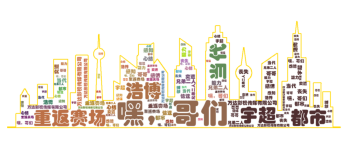

'/content/drive/MyDrive/Github/Article/img/ChinaFilm_Reg_Overview_嘿，哥们_psychedelic-1084082_960_720_2021年8月整月.png'

《刀·风》
编剧：吴孟璋，（其它作品：《密室逃生》、《奔腾岁月》、《我的喜马拉雅》、《钢铁，是这样炼成的》、《刀风》、《刀比枪快》、《火痛》）
备案单位：腾讯影业（深圳）有限公司


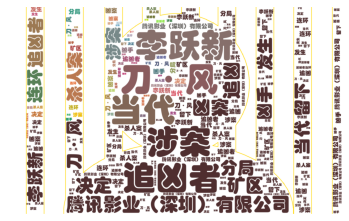

'/content/drive/MyDrive/Github/Article/img/ChinaFilm_Reg_Overview_刀·风_psychedelic-1084082_960_720_2021年8月整月.png'

《喜从天降》
编剧：孙延昊
备案单位：万达影业（长春）有限公司


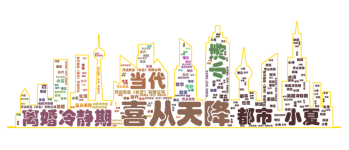

'/content/drive/MyDrive/Github/Article/img/ChinaFilm_Reg_Overview_喜从天降_psychedelic-1084082_960_720_2021年8月整月.png'

《筐出未来》
编剧：吴潮威、耿漪淼、刘泽敏、刘维
备案单位：奥飞影业（上海）有限公司、广东原创动力文化传播有限公司


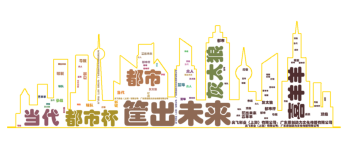

'/content/drive/MyDrive/Github/Article/img/ChinaFilm_Reg_Overview_筐出未来_psychedelic-1084082_960_720_2021年8月整月.png'

《贝肯熊3：火星任务》
编剧：刘珮如、王超
备案单位：奥飞影业（上海）有限公司


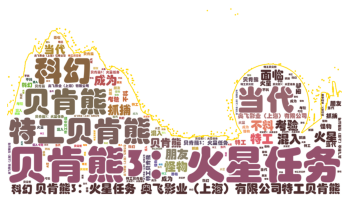

'/content/drive/MyDrive/Github/Article/img/ChinaFilm_Reg_Overview_贝肯熊3：火星任务_psychedelic-1084082_960_720_2021年8月整月.png'

In [240]:
for i in df_focus_narrowed.index:
  ls = [df_focus_narrowed.loc[i, '片名']] * 20
  ls += [df_focus_narrowed.loc[i, '预测片名']] *10
  ls += df_focus_narrowed.loc[i, '主要角色']*6
  ls += [df_focus_narrowed.loc[i, '修正类型']] *3
  ls += [df_focus_narrowed.loc[i, '年代']]*3
  ls += df_focus_narrowed.loc[i, 'kw']*2
  ls += [df_focus_narrowed.loc[i, '备案单位']]*3
  img_fn = df_focus_narrowed.loc[i, 'src_img']
  if not img_fn:
    img_fn = df_label2image.loc[
      df_label2image['label'] == df_focus_narrowed.loc[i, '修正类型'],
      'fn'
  ].iloc[0]
  txt = '《{}》'.format(df_focus_narrowed.loc[i, '片名'])
  txt += '\n编剧：{}'.format(df_focus_narrowed.loc[i, '编剧'])
  writer_works = df.loc[df['编剧'] == df_focus_narrowed.loc[i, '编剧'], 
                        '片名'].to_list()
  if len(writer_works) > 1:
    writer_works.remove(df_focus_narrowed.loc[i, '片名'])
    txt += '，（其它作品：《{}》）'.format('》、《'.join(writer_works))
  
  txt += '\n备案单位：{}'.format(df_focus_narrowed.loc[i, '备案单位'])
  print(txt)
  fp_img = path_img + '/genre_icon/{}'.format(img_fn)
  fp_mask = path_img + '/genre_icon/{}'.format('mask_' + img_fn)
  fp_img = path_img + '/genre_icon/{}'.format('psychedelic-1084082_960_720.jpg')
  fp_generated_img = generate_word_image(ls, fp_img, fp_mask)
  display(fp_generated_img)
  df_focus_narrowed.loc[i, 'tgt_img'] = fp_generated_img

## 【P6】编剧 WIP

In [ ]:
df_curr['编剧']

df_writers = df.loc[df['编剧'].isin(df_curr['编剧'].unique()),:]
df_writers = df_writers[df_writers['电影类别'] == '故事影片']
df_writer_nfilms = df_writers.groupby('编剧')['片名'].count().rename('作品数量').reset_index()
df_writers = df_writers.merge(df_writer_nfilms, on='编剧', how='left')

df_writers[df_writers['作品数量'] >1]

## 【S0】 生成摘要
2021年4月28日，3月的电影备案公示发布，其中最遥远的是影剧备字〔2021〕第1360号的《幕后英雄》，最近期的是影特备字〔2021〕第006号的《熊猫传奇——黑洞之吻》，慷田AI聚焦、重点关注的项目有中国电影的《发明一个夏天》、光线的《计划外的姐弟恋》、《二郎神》、《土行孙之破土重生》、爱奇艺的《日常警事》以及阿里的《无价之宝》。

In [241]:
df_focus_narrowed['单位简称'] = df_focus_narrowed['备案单位'].str.extract('('+ pat_public + ")")
df_f = df_focus_narrowed.groupby('单位简称')['片名'].apply(
    lambda x: '、'.join('《' + x + '》')).rename('关注影片').reset_index()
#####
S0 = '{year}年{month}月{day}日，'.format(
    year=pub_year, month=pub_month, day=pub_day)

S0 +=  '{month}月'.format(month=df_curr.iloc[0]['公示批次起始'][1])
if df_curr.iloc[0]['公示批次起始'][2] != '整月':
  S0 += '{duration}'.format(duration=df_curr.iloc[0]['公示批次起始'][2])

S0 += '电影备案共计{}部，其中'.format(df_curr.shape[0])
S0 += '最遥远的是{}的《{}》，'.format(
    df_curr_sorted.loc[0, '备案立项号'], df_curr_sorted.loc[0, '片名'])
S0 += '最近期的是{}的《{}》，'.format(
    df_curr_sorted.loc[df_curr.shape[0]-1, '备案立项号'], 
    df_curr_sorted.loc[df_curr.shape[0]-1, '片名']
)

S0 += '慷田AI聚焦关注的项目有'
for i, row in df_f.iterrows():
  if i == df_f.shape[0]-1:
    S0 = S0.rstrip('、')
    S0 += '以及{co}的{film}'.format(co=row['单位简称'], film=row['关注影片'])
  else:
    S0 += '{co}的{film}、'.format(co=row['单位简称'], film=row['关注影片'])
S0 += '。'

print(S0)

2021年9月30日，8月电影备案共计211部，其中最遥远的是影特备字〔2021〕第011号的《东方欲晓之曙光》，最近期的是影剧备字〔2021〕第2569号的《你是我天使2》，慷田AI聚焦关注的项目有万达的《嘿，哥们》、《喜从天降》、奥飞的《筐出未来》、《贝肯熊3：火星任务》以及腾讯的《刀·风》。


## 【R1】 指向电影剧官网


In [242]:
#####
R1 = '\n\n'
R1 += '慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。'
R1 += '电影立项备案公示信息来自中国国家电影局 China Film Administration, 官方网址 '
R1 += ' http://www.chinafilm.gov.cn/chinafilm 。'

print(R1)



慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。电影立项备案公示信息来自中国国家电影局 China Film Administration, 官方网址  http://www.chinafilm.gov.cn/chinafilm 。


## 【R2，R3】, Pointer Text

In [247]:
R2 = '点击左下角阅读原文查看本期慷田AI影片信息详表。'
R3 = '点击左下角阅读原文查看本期慷田AI影片概览分析。'

## Save or load df_{issue_name}

In [ ]:
df_curr

In [244]:
# Save records for current reg issue
path_records = '/content/drive/MyDrive/Github/Article/records'
df_curr.to_pickle(path_records + '/df_reg_{}.pkl'.format(issue_name))

In [ ]:
#df_curr.read_pickle(path_records + '/df_reg_{}.pkl'.format(issue_name))

#[4] Output Word Document

## Install and Load Libraries

In [ ]:
%%capture
!pip install python-docx
!pip install lxml
from docx import Document
from docx.shared import Inches
from docx.oxml.ns import qn
#from docx.text.parargaph import Paragraph

## Write Overview to docx and download


In [248]:
path_doc = '/content/drive/MyDrive/Github/Article/docx'

doc = Document()

# Set document Font 
doc.styles['Normal'].font.name = '微软雅黑'
r = doc.styles['Normal']._element
r.rPr.rFonts.set(qn('w:eastAsia'), '微软雅黑')

# Title
doc.core_properties.title = 'China Film Registration Overview {}'.format(
    issue_name)

doc.add_heading(T1, 0)
p = doc.add_paragraph(S0, style='Intense Quote')

doc.add_paragraph(P1)

doc.add_picture(fp_plot_type, width =Inches(4))
doc.add_paragraph(P2)

doc.add_picture(fp_plot_genre, width =Inches(4))
doc.add_paragraph(P3)

doc.add_picture(fp_plot_time, width =Inches(4))
doc.add_paragraph(P4)

doc.add_paragraph(P5)
for i in df_focus_narrowed.index:
  txt = '《{}》'.format(df_focus_narrowed.loc[i, '片名'])
  txt += '\n编剧：{}'.format(df_focus_narrowed.loc[i, '编剧'])

  if df.loc[df['编剧'].str.contains(df_focus_narrowed.loc[i, '编剧']),
            '片名'
            ].shape[0] > 1:
    writer_works = df.loc[
        df['编剧'].str.contains(df_focus_narrowed.loc[i, '编剧']), 
        '片名'
        ].to_list()
    writer_works.remove(df_focus_narrowed.loc[i, '片名'])
    txt += '，（其它作品：《{}》）'.format('》、《'.join(writer_works))
  
  txt += '\n备案单位：{}'.format(df_focus_narrowed.loc[i, '备案单位'])
  doc.add_paragraph(txt)
  doc.add_picture(df_focus_narrowed.loc[i, 'tgt_img'], width=Inches(4))

doc.add_paragraph(R1)
doc.add_paragraph(R2)

fp_doc = path_doc + '/ChinaFilm_Reg_Overview_' + issue_name + '.docx'
doc.save(fp_doc)

In [246]:
# Download Document
from google.colab import files
files.download(fp_doc)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Write Table to docx

In [ ]:
path_doc = '/content/drive/MyDrive/Github/Article/docx'

doc = Document()

# Set document Font 
doc.styles['Normal'].font.name = '微软雅黑'
r = doc.styles['Normal']._element
r.rPr.rFonts.set(qn('w:eastAsia'), '微软雅黑')

# Title
doc.core_properties.title = 'China Film Registration Table {}'.format(
    issue_name)

doc.add_heading('详表：{}'.format(T1), 0)
p = doc.add_paragraph(S0, style='Intense Quote')

table = doc.add_table(rows=1, cols=1, style='Light List Accent 4')

df_curr_sorted = df_curr.sort_values(
    ['电影类别', '类型'], ascending=[False, True])
i = 1
for _, row in df_curr_sorted.iterrows():
  row_cells = table.add_row().cells
  row_cells[0].text = '[' + str(i) + ']' + '《'.format(i) + row['片名'] + '》'

  row_cells = table.add_row().cells
  row_cells[0].text = '编剧: ' + row['编剧']
  if df.loc[df['编剧'].str.contains(row['编剧']), '片名'].shape[0] > 1:
    writer_works = df.loc[df['编剧'].str.contains(row['编剧']), 
                          '片名'].to_list()
    if len(writer_works) > 1:
      writer_works.remove(row['片名'])
      txt = '《{}》'.format('》、《'.join(writer_works))
    row_cells = table.add_row().cells
    row_cells[0].text = '其它作品：' + txt

  row_cells = table.add_row().cells
  row_cells[0].text = '备案单位: ' + row['备案单位']

  row_cells = table.add_row().cells
  row_cells[0].text = '类别：{}，类型:{} ，年代:{}'.format(
      row['电影类别'], row['类型'], row['年代'])

  row_cells = table.add_row().cells
  row_cells[0].text = row['梗概']

  row_cells = table.add_row().cells
  row_cells[0].text = ''
  i+=1

doc.add_paragraph(R1)
doc.add_paragraph(R3)

fp_doc = path_doc + '/ChinaFilm_Reg_Table_' + issue_name + '.docx'
doc.save(fp_doc)

In [ ]:
# Download Document
from google.colab import files
files.download(fp_doc)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>